<h1 align="center">OpenMP part 2</h1> 

## Exercise 1:

Using your code 2D non linear convection equation from the `numba_pyccel_assignments`:
1. Parallelize the 2D non linear convection equation
2. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [30]:
# write your code here

def solve_2d_nonlinearconv_pyccel(u:'float[:,:]', un:'float[:,:]', v:'float[:,:]', vn:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float',l:'int'):
              ###   Assign initial conditions
              ##   set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2 
    
    #$ omp parallel num_threads(l)
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##   set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    #$ omp barrier
          #fill the update of u and v
   
    #$ omp for
    for t in range(nt):
        un[:,:]=u[:,:]
        vn[:,:]=v[:,:]
                    # mise a jour    
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j]=un[i,j]- un[i,j]*(dt/dx)*(un[i,j]-un[i-1,j]) - vn[i,j]*(dt/dy)*(un[i,j]-un[i,j-1]) 
                v[i,j]=vn[i,j]- un[i,j]*(dt/dx)*(vn[i,j]-vn[i-1,j]) - vn[i,j]*(dt/dy)*(vn[i,j]-vn[i,j-1]) 
     
    #$ omp end parallel    
    return 0


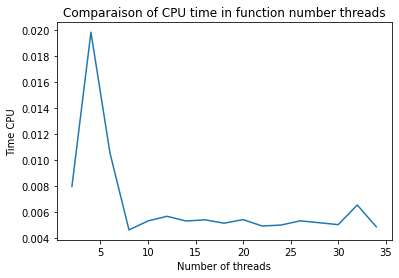

In [31]:
from pyccel.epyccel import epyccel
from pyccel.decorators import types
import matplotlib.pyplot as plt
import time
import numpy as np

###variable declarations
nx = 101
ny = 101
nt = 80
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))     


f1=epyccel(solve_2d_nonlinearconv_pyccel,accelerators=['openmp'])

n=[2,4,6,8,10,12,14,16,18,20,22,24,26,30,32,34]
tmp=[]
for t in n:
    t1=time.process_time()
    f1(u,un,v,vn,nt,dt,dx,dy,t)
    t2=time.process_time()-t1
    tmp.append(t2)
    
plt.plot(n,tmp)
plt.xlabel('Number of threads')
plt.ylabel('Time CPU')
plt.title('Comparaison of CPU time in function number threads')
plt.show()

## Exercise 2:

Using your code Navier Stokes equation from the `numba_pyccel_assignments`:
1. Pyccelize the Navier Stokes equation (if it's not done).
2. Parallelize it using OpenMP.
3. Compare cpu time using different number of threads (Plot a figure of cpu time according to number of threads)

In [27]:

def navier_openmp(nit:'int',nt:'int', u:'float[:,:]',un:'float[:,:]',b:'float[:,:]',v:'float[:,:]', vn:'float[:,:]',dt:'float', nx:'int', ny:'int', dx:'float', dy:'float', p:'float[:,:]', pn:'float[:,:]',rho:'int', nu:'float',num:'int'):
    #un = u
    #vn = v
    #b = u
   
    #$ omp parallel num_threads(num)
    #$ omp for
   
    for n in range(nt):
        un[:,:] = u[:,:]
        vn[:,:] = v[:,:]
       

    #$ omp sections
    #$ omp section
   
     # Calcul de p
        row, col = p.shape
        b[1:-1, 1:-1] = (rho * (1 / dt *
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) /
                         (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                        ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                          2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                               (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                              ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
       
    #$ omp end section
   
    #$ omp section
   
    # Calcul de p
        pn[:,:] = p[:,:]
   
        #$ omp for
        for q in range(nit):
            pn[:,:] = p[:,:]
            p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                                (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                                (2 * (dx**2 + dy**2)) -
                                dx**2 * dy**2 / (2 * (dx**2 + dy**2)) *
                                b[1:-1,1:-1])

            p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
            p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
            p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
            p[-1, :] = 0        # p = 0 at y = 2
    #$ omp end section
   
    #$ omp section
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))
   
        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
    #$ omp end section
    #$ omp end sections
    #$ omp end parallel
       
 #   return u, v, p

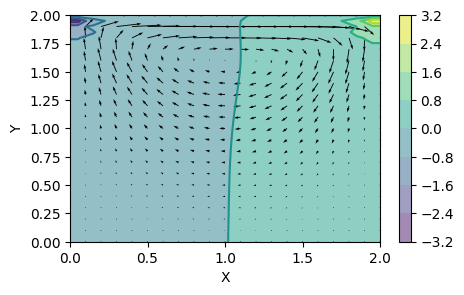

In [28]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
un = np.zeros((ny, nx))
vn = np.zeros((ny, nx))
p = np.zeros((ny, nx)) 
pn = np.zeros((ny, nx)) 
b = np.zeros((ny, nx))
num = 1
navier_openmp(nit,nt,u, un, b ,v, vn, dt, nx, ny, dx, dy, p, pn, rho, nu,num)

fig = pyplot.figure(figsize=(5, 3), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
pyplot.colorbar()
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

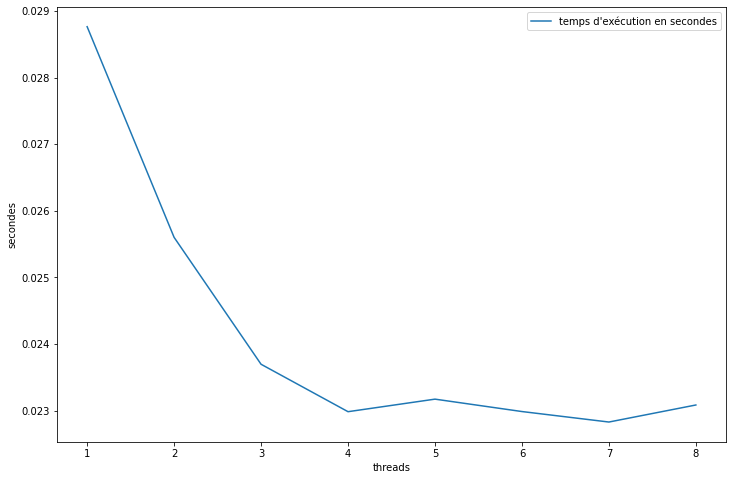

In [36]:
from pyccel.epyccel import epyccel
from pyccel.stdlib.internal.openmp import omp_set_num_threads
execute = epyccel(navier_openmp, language="c", accelerators= ' openmp ')
import timeit
threads = 9
temps_execution = []
for i in range(1,threads):
    #omp_set_num_threads(i)
    t1 = timeit.default_timer()
    execute(nit,nt,u, un, b ,v, vn, dt, nx, ny, dx, dy, p, pn, rho, nu,i)
    temps_execution.append(timeit.default_timer() - t1)
#print(temps_execution) 

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
threads = np.arange(1,9,1)
plt.plot(threads,temps_execution, label='temps d\'exécution en secondes')
plt.xlabel("threads")
plt.ylabel("secondes")
plt.legend()
plt.show()